In [43]:
import pandas as pd

# Load the dataset
df = pd.read_csv("url_spam_classification.csv")


df.rename(columns={"url":"URL" , "is_spam":"Label"} , inplace = True )

def classifi(x):
    if x == True:
        return "good"
    else:
        return "bad"
    
df['Label'] = df["Label"].apply(lambda x: classifi(x)) 

# Show basic info
df.info()

# Display first few rows
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148303 entries, 0 to 148302
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     148303 non-null  object
 1   Label   148303 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


,URL,Label
0,https://briefingday.us8.list-manage.com/unsubs...,good
1,https://www.hvper.com/,good
2,https://briefingday.com/m/v4n3i4f3,good
3,https://briefingday.com/n/20200618/m#commentform,bad
4,https://briefingday.com/fan,good


In [44]:
df[df['Label'] == "bad"]['URL'].values[20]

'http://josefschulz.com/uebergang/'

In [45]:
# Check for missing values
df.isnull().sum()

# Check label distribution
df['Label'].value_counts()


bad     101021
good     47282
Name: Label, dtype: int64

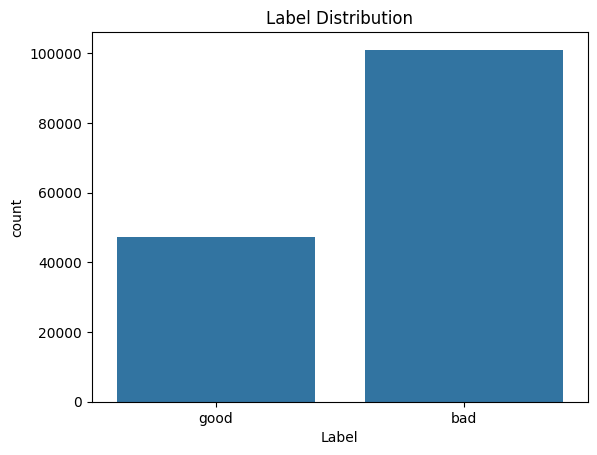

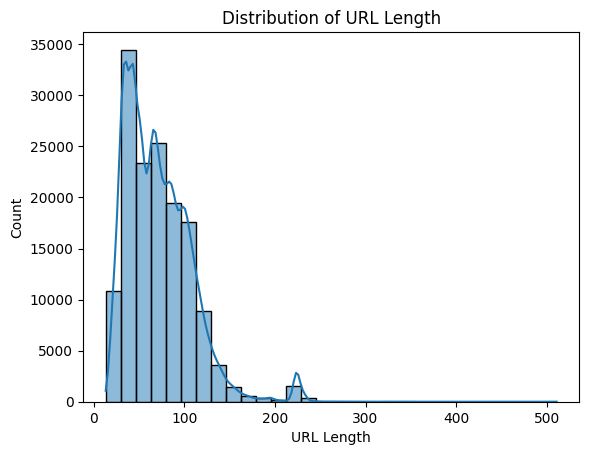

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize label distribution
sns.countplot(x='Label', data=df)
plt.title("Label Distribution")
plt.show()

# URL length distribution
df['url_length'] = df['URL'].apply(len)

sns.histplot(df['url_length'], kde=True, bins=30)
plt.title("Distribution of URL Length")
plt.xlabel("URL Length")
plt.show()


In [47]:
import re
from urllib.parse import urlparse

# Feature: URL length
df['url_length'] = df['URL'].apply(len)

# Feature: Number of dots in the URL
df['dot_count'] = df['URL'].apply(lambda x: x.count('.'))

# Feature: Uses IP address instead of domain
df['has_ip'] = df['URL'].apply(lambda x: 1 if re.match(r'^(http[s]?://)?(\d{1,3}\.){3}\d{1,3}', x) else 0)

# Feature: Count of hyphens (often used to impersonate domains)
df['hyphen_count'] = df['URL'].apply(lambda x: x.count('-'))

# Feature: Count of '@' symbols (used to redirect to a malicious site)
df['at_count'] = df['URL'].apply(lambda x: x.count('@'))

# Feature: Count of suspicious characters often seen in phishing URLs
df['suspicious_char_count'] = df['URL'].apply(lambda x: x.count('=') + x.count('&') + x.count('%'))

# Feature: URL has long path (may try to obscure intent)
df['path_length'] = df['URL'].apply(lambda x: len(urlparse(x).path))

# Feature: URL has long query string
df['query_length'] = df['URL'].apply(lambda x: len(urlparse(x).query))

# Feature: Is HTTPS (generally safer but not guaranteed)
df['is_https'] = df['URL'].apply(lambda x: 1 if x.startswith('https') else 0)

# Feature: Uses shortening service (bit.ly, tinyurl, etc.)
shorteners = ['bit.ly', 'goo.gl', 'tinyurl', 'ow.ly', 't.co', 'is.gd', 'buff.ly']
df['is_shortened'] = df['URL'].apply(lambda x: 1 if any(s in x for s in shorteners) else 0)


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode the label: 'bad' -> 0, 'good' -> 1
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

# Select security-focused features
features = [
    'url_length',
    'dot_count',
    'has_ip',
    'hyphen_count',
    'at_count',
    'suspicious_char_count',
    'path_length',
    'query_length',
    'is_https',
    'is_shortened'
]

X = df[features]
y = df['Label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nAccuracy Score: {accuracy_score(y_test, y_pred):.4f}")


Confusion Matrix:
[[19028  1176]
 [  965  8492]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     20204
           1       0.88      0.90      0.89      9457

    accuracy                           0.93     29661
   macro avg       0.92      0.92      0.92     29661
weighted avg       0.93      0.93      0.93     29661


Accuracy Score: 0.9278


In [50]:
import joblib

# After training
joblib.dump(model, 'rf_model.pkl')


['rf_model.pkl']

In [54]:
import numpy as np
from urllib.parse import urlparse
import joblib


def extract_features(url):
    shorteners = ['bit.ly', 'goo.gl', 'tinyurl', 'ow.ly', 't.co', 'is.gd', 'buff.ly']
    
    return np.array([[
        len(url),                            # url_length
        url.count('.'),                      # dot_count
        1 if re.match(r'^(http[s]?://)?(\d{1,3}\.){3}\d{1,3}', url) else 0,  # has_ip
        url.count('-'),                      # hyphen_count
        url.count('@'),                      # at_count
        url.count('=') + url.count('&') + url.count('%'),  # suspicious_char_count
        len(urlparse(url).path),             # path_length
        len(urlparse(url).query),            # query_length
        1 if url.startswith('https') else 0, # is_https
        1 if any(s in url for s in shorteners) else 0       # is_shortened
    ]])

def predict_url_safety(url):

    model = joblib.load('rf_model.pkl')
    features = extract_features(url)
    pred = model.predict(features)[0]
    label = 'Safe ✅' if pred == 1 else 'Unsafe ❌'
    return label

# Example usage:
example_url = "https://www.github.com"
predict_url_safety(example_url)


/home/user/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


'Safe ✅'

/tmp/ipykernel_8850/2337672757.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
/tmp/ipykernel_8850/2337672757.py:20: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
/home/user/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


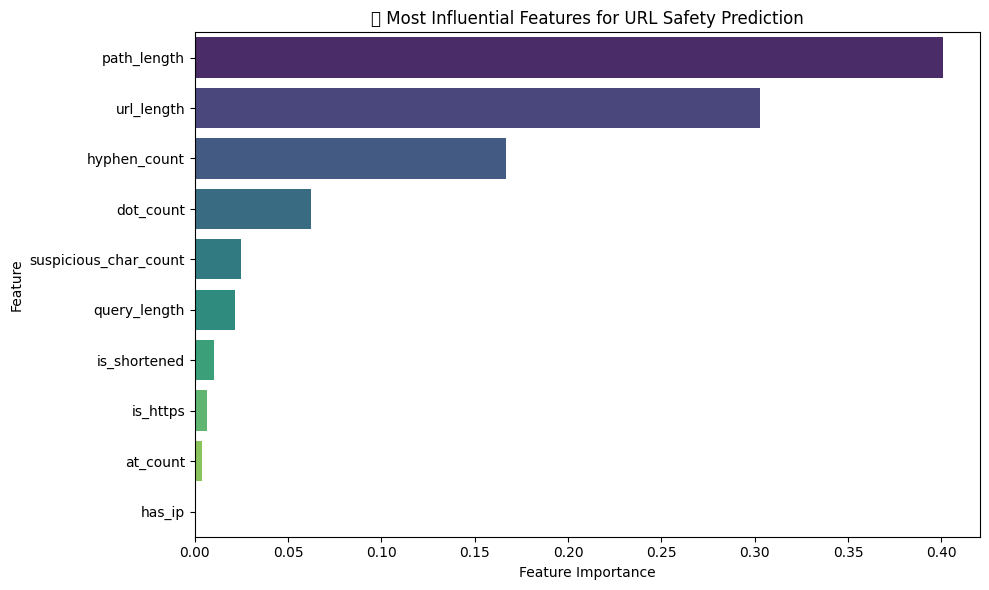

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the model
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy plotting
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
plt.title('🔍 Most Influential Features for URL Safety Prediction')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
